In [52]:
from functools import partial

import torch
import torch.nn as nn
import numpy as np

import wandb
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

import importlib
import NeuralGraph
importlib.reload(NeuralGraph)
from message import *
from update import *
from attention import *

In [53]:
DEVICE = 'cpu'
BS = 64
NODES = 4

ch_n = 8
ch_e = 8
ch_k = 8
ch_extra = 6

message_gen = lambda **kw: nn.Sequential(
    nn.Linear((ch_n+ch_extra)*2 + ch_e, ch_n*2 + ch_e),
    nn.ReLU(),
)

update_gen = lambda **kw: nn.Sequential(
    nn.Linear(ch_n*3 + ch_extra, ch_n),
)

attention_gen = lambda **kw: nn.Sequential(
    nn.Linear(ch_n+ch_extra, ch_k*4),
)


ngraph = NeuralGraph.NeuralGraph(
    NODES, 1, 1,
    message_generator=message_gen,
    update_generator=update_gen,
    attention_generator=attention_gen,
    aggregation='attention',
    value_init='trainable',
    # connections = [(i, i+1) for i in range(NODES-1)],
    connections = [(0,1), (2, 3)],
    ch_n=ch_n, ch_e=ch_e, ch_k=ch_k,
    n_models=1,
    leakage=0.5,
).to(DEVICE)

In [54]:
STEPS = 1_000

criterion = nn.MSELoss()

optimizer = torch.optim.Adam(ngraph.parameters(), lr=1e-3, weight_decay=0.0)
# optimizer = torch.optim.RMSprop(ngraph.parameters(), lr=1e-3, weight_decay=0.0)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, STEPS)
log = []

In [55]:
bar = tqdm(range(STEPS))
for i in enumerate(bar):
    x = torch.randint(0, 2, size=(BS, 1), device=DEVICE).float()
    y = x

    ngraph.init_vals(batch_size=BS)
    y_hat = ngraph.forward(x, time=10, dt=1, nodes=True, edges=True)

    task_loss = criterion(y, y_hat)
    overflow = ngraph.overflow()
    loss = task_loss + overflow
    
    if ngraph.leakage <= 0.001:
        ngraph.leakage = 0
    elif loss.item() < 0.2:
        ngraph.leakage -= 0.01

    optimizer.zero_grad()
    loss.backward()
    torch.nn.utils.clip_grad_norm_(ngraph.parameters(), 1.0)
    optimizer.step()
    scheduler.step()

    mgrad = torch.norm(next(ngraph.messages.parameters()).grad.detach())
    ugrad = torch.norm(next(ngraph.updates.parameters()).grad.detach())
    node_grad = torch.norm(ngraph.init_nodes.grad)
    edge_grad = torch.norm(ngraph.init_edges.grad)
    
    entry = {
        'loss': task_loss.item(),
        'overflow': overflow.item(),
        'mgrad': mgrad.item(),
        'ugrad': ugrad.item(),
        'node_grad': node_grad.item(),
        'edge_grad': edge_grad.item(),
    }
    
    bar.set_postfix(entry)
    log.append(entry)
print(f'final loss: {log[-1]["loss"]:.4f}')

 13%|█▎        | 131/1000 [00:08<00:57, 15.15it/s, loss=0.267, overflow=0, mgrad=0.477, ugrad=0.739, node_grad=0.0271, edge_grad=0.0388]      


Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "C:\Users\Alec\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\IPython\core\interactiveshell.py", line 3508, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\Alec\AppData\Local\Temp\ipykernel_23760\3663534259.py", line 7, in <module>
    y_hat = ngraph.forward(x, time=10, dt=1, nodes=True, edges=True)
  File "c:\Users\Alec\Documents\GitHub\ngraph_lang\NeuralGraph.py", line 435, in forward
    Takes an input x and a label y and puts them in the graph and runs the graph for a certain amount of time with a certain time resolution.
  File "c:\Users\Alec\Documents\GitHub\ngraph_lang\NeuralGraph.py", line 227, in timestep
  File "C:\Users\Alec\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\torch\nn\modules\module.py", line 1501, in _call_impl
    return forward_call(

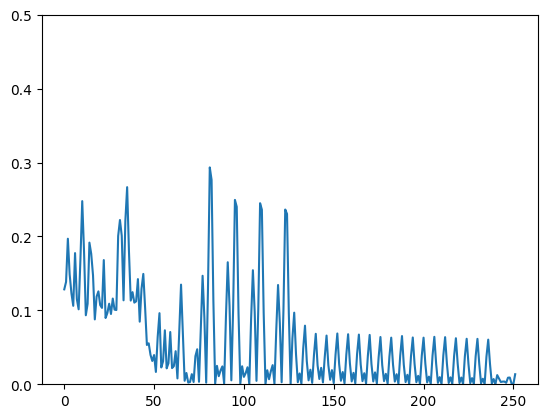

In [40]:
# my_log = torch.load("my_log.pt")
plt.plot([e["loss"] for e in log], label='yours')
# plt.plot([e["loss"] for e in my_log], label='mine', alpha=0.5)
plt.ylim(0, 0.5)
# plt.legend()
plt.show()

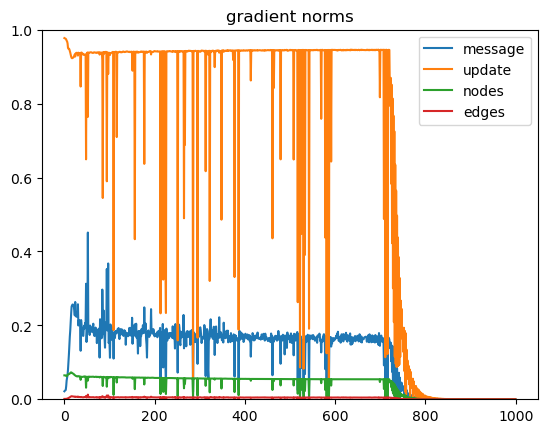

In [10]:
plt.plot([e["mgrad"] for e in log], label='message')
plt.plot([e["ugrad"] for e in log], label='update')
plt.plot([e["node_grad"] for e in log], label='nodes')
plt.plot([e["edge_grad"] for e in log], label='edges')
plt.title('gradient norms')
plt.ylim(0, 1.0)
plt.legend()
plt.show()